# Import Modules

In [1]:
import numpy as np
import re
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import pickle
import tensorflow as tf

from tqdm import tqdm
from PIL import Image

from nltk.translate.bleu_score import corpus_bleu

from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [2]:
# Set the GPU device
physical_devices = tf.config.list_physical_devices('GPU')
print(f"GPUs detected: {len(physical_devices)}")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs detected: 1


# Extract Image Features

In [3]:
model = ResNet152()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Load Images

In [4]:
features_df = {}
with open(os.path.join(os.getcwd(), 'features.pkl'), 'rb') as f:
    features_df = pickle.load(f)
    
features_df.head()

,image_id,features
0,1282392036_5a0328eb86,"[[0.105682276, 0.035767782, 1.0629623, 0.16100..."
1,751737218_b89839a311,"[[0.6057889, 0.0, 1.3023336, 0.66097057, 0.049..."
2,446138054_d40c66d5f0,"[[0.3361557, 0.5220064, 0.9230697, 0.06353588,..."
3,191003285_edd8d0cf58,"[[0.0944398, 0.028939137, 0.8067281, 0.0046310..."
4,3249865395_dceaa59f54,"[[0.6526645, 0.067537695, 0.9309761, 0.8532998..."


# Load Captions

In [5]:
# Read the captions into a dataframe
captions_df = pd.read_csv("captions.txt")
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [6]:
# Remove the file extension for each image
captions_df['image'] = captions_df['image'].str.replace(r'\.\w+$', '', regex=True)

# Group captions together in a list by their image name
grouped_df = captions_df.groupby('image')['caption'].apply(list).reset_index(name='captions')
grouped_df.head()

,image,captions
0,1000268201_693b08cb0e,[A child in a pink dress is climbing up a set ...
1,1001773457_577c3a7d70,"[A black dog and a spotted dog are fighting, A..."
2,1002674143_1b742ab4b8,[A little girl covered in paint sits in front ...
3,1003163366_44323f5815,[A man lays on a bench while his dog sits by h...
4,1007129816_e794419615,[A man in an orange hat starring at something ...


# Preprocess Text Data

In [7]:
def remove_non_alpha(sentence):
    sentence = re.sub(r'[^A-Za-z]', ' ', sentence)

    return sentence

def remove_extra_space(sentence):
    sentence = re.sub(r'\s+', ' ', sentence.strip())
    return sentence

def remove_single_char(sentence):
    sentence = " ".join([word for word in sentence.split() if len(word) > 1])
    return sentence

def sanitize_text(grouped_df):
    for index, row in grouped_df.iterrows():
        image_captions = row['captions']
        
        for i in range(len(image_captions)):
            image_caption = image_captions[i]

            image_caption = image_caption.lower()

            image_caption = remove_non_alpha(image_caption)
            image_caption = remove_extra_space(image_caption)
            image_caption = remove_single_char(image_caption)
            
            image_caption = f"startseq {image_caption} endseq"

            image_captions[i] = image_caption
    
    return grouped_df

In [8]:
sanitized_df = sanitize_text(grouped_df)

all_captions = []
for index, row in sanitized_df.iterrows():
    caption_list = row['captions']
    for caption in caption_list:
        all_captions.append(caption)

len(all_captions)

40455

In [9]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [10]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [11]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
vocab_size

8427

# Train-Test Split

In [12]:
train_data, test_data = train_test_split(sanitized_df['image'].tolist(), test_size=0.1, random_state=42)
print(f"{len(train_data)}: {len(test_data)}")

7281: 810


# Model Creation


In [13]:
embedding_dim = 512
batch_size = 16
units = 512

In [103]:
class CNNEncoder(tf.keras.Model):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.fc = tf.keras.layers.Dense(512, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.4)

    def call(self, inputs):
        x = self.fc(inputs)
        x = tf.nn.relu(x)
        return x

class RNNDecoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNNDecoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        self.fc1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.5)
        self.batchnormalization = tf.keras.layers.BatchNormalization(epsilon=1e-6, momentum=0.9)

        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Bahdanau attention parameters
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)

    def call(self, x, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # Score equation: score(h_t, h_s) = v^T tanh(W_1 h_t + W_2 h_s)
        score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
        
        attention_weights = tf.nn.softmax(score, axis=1)

        # Context vector: h_s = \sum_{i=1}^{T_x} \alpha(h_t, h_s) * h_s
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        x = self.fc1(output)

        x = tf.reshape(x, (-1, x.shape[2]))

        x = self.dropout(x)
        x = self.batchnormalization(x)

        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    
class ImageCaptionModel(tf.keras.Model):
    def __init__(self, vocab_size, max_length):
        super(ImageCaptionModel, self).__init__()
        self.cnn_model = CNNEncoder()
        self.rnn_model = RNNDecoder(embedding_dim=embedding_dim, units=units, vocab_size=vocab_size)

    def call(self, inputs, hidden_state):
        x1, x2 = inputs

        features = self.cnn_model(x1)
        caption_output, _, _ = self.rnn_model(x2, features, hidden_state)

        return caption_output

In [104]:
model = ImageCaptionModel(vocab_size, max_length)

In [121]:
def data_generator(data_keys, mapping_df, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1

            row = mapping_df[mapping_df['image'] == key]
            captions_list = row['captions'].iloc[0]
            for caption in captions_list:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    image_feat = features.loc[features['image_id'] == key, 'features'].iloc[0][0]

                    X1.append(image_feat)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                # Reshape X1 to match the input shape of the CNN
                X1 = np.reshape(X1, (batch_size, 1, embedding_dim))

                # Initialize hidden state with zeros
                hidden_state = np.zeros((batch_size, units))

                yield [X1, X2], y, hidden_state

                X1, X2, y = [], [], []
                n = 0

In [122]:
epochs = 30
batch_size = 16
steps = len(train_data) // batch_size

train_loss_history = []

# Compile the model with an appropriate optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Create a directory to save the checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

for i in range(epochs):
    generator = data_generator(train_data, sanitized_df, features_df, tokenizer, max_length, vocab_size, batch_size)

    for j in range(steps):
        batch_inputs, batch_labels, hidden_state = next(generator)

        # Extract image features, captions, and hidden state from batch_inputs
        image_features = batch_inputs[0]
        captions = batch_inputs[1]

        with tf.GradientTape() as tape:
            # Pass inputs and hidden state to the model and obtain predictions
            predictions, _, _ = model([captions[:, :-1], image_features], hidden_state)

            # Calculate loss
            loss = loss_function(captions[:, 1:], predictions)

            # Apply gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss_history.append(loss.numpy())

    # Save the model checkpoint
    checkpoint_name = f"model_{i+1}_loss_{train_loss_history[-1]}.h5"
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    model.save_weights(checkpoint_path)

InvalidArgumentError: Exception encountered when calling layer "rnn_decoder_20" "                 f"(type RNNDecoder).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} ConcatOp : Ranks of all input tensors should match: shape[0] = [16,1,512] vs. shape[1] = [3344,1,512,512] [Op:ConcatV2] name: concat

Call arguments received by layer "rnn_decoder_20" "                 f"(type RNNDecoder):
  • x=tf.Tensor(shape=(3344, 1, 512), dtype=float32)
  • features=tf.Tensor(shape=(836, 512), dtype=float32)
  • hidden=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

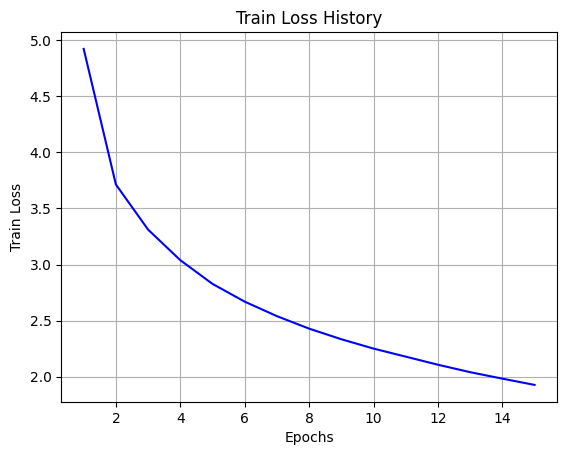

In [ ]:
# Plot the train loss history
plt.plot(range(1, epochs+1), train_loss_history, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Train Loss History')
plt.grid(True)
plt.show()

In [ ]:
checkpoints_dir = 'checkpoints'
model_list = os.listdir(checkpoints_dir)

model_losses_mapping = {}
for model in model_list:
    loss = (model.split("_")[-1]).split(".h5")[0]
    model_losses_mapping[model] = float(loss)

best_model = max(model_losses_mapping, key=model_losses_mapping.get)
model = load_model(os.path.join(checkpoints_dir, best_model))
print(f"Loaded: {best_model}")

Loaded: model_15_loss_1.9258904457092285.h5


# Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def greedy_search(model, image, tokenizer, max_length):
    in_text = "startseq"
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)

        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break

        in_text += " " + word

        if word == "endseq":
            break
      
    return in_text

In [ ]:
for key in tqdm(test_data):
    test_feature = features_df.loc[features_df['image_id'] == key, 'features'].iloc[0][0]

100%|██████████| 810/810 [00:00<00:00, 1548.77it/s]


In [ ]:
# Validate with test data
actual, predicted = [], []

for key in tqdm(test_data):
    caption = captions_df.loc[captions_df['image'] == key, 'caption'].iloc[0]

    y_pred = greedy_search(model, features_df.loc[features_df['image_id'] == key, 'features'].iloc[0], tokenizer, max_length)

    actual_captions = [caption.split()]
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)


  1%|          | 8/810 [00:08<13:43,  1.03s/it]


KeyboardInterrupt: 

In [ ]:
# Calculate 1-gram, 2-gram, 3-gram, and 4-gram BLEU scores
print(f"BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}")
print(f"BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}")
print(f"BLEU-3: {corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))}")
print(f"BLEU-4: {corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))}")

BLEU-1: 0.1605736507015259
BLEU-2: 0.08090996159133797
BLEU-3: 0.039594357638526124
BLEU-4: 0.016709217055823698


# Visualize Results

In [ ]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(os.getcwd(), "Images", image_name)
    image = Image.open(img_path)
    captions = sanitized_df.loc[grouped_df['image'] == image_id, 'captions'].values[0]

    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    y_pred = greedy_search(model, features_df.loc[features_df['image_id'] == image_id, 'features'].iloc[0], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq soccer player in blue is chasing after the player in black and white endseq
startseq the girl in the white strip is falling down as the girl in the blue strip challenges for the soccer ball endseq
startseq the girls are playing soccer endseq
startseq two women in soccer uniforms playing soccer endseq
startseq two young women on different teams are playing soccer on field endseq
--------------------Predicted--------------------
startseq two boys are playing soccer in field endseq


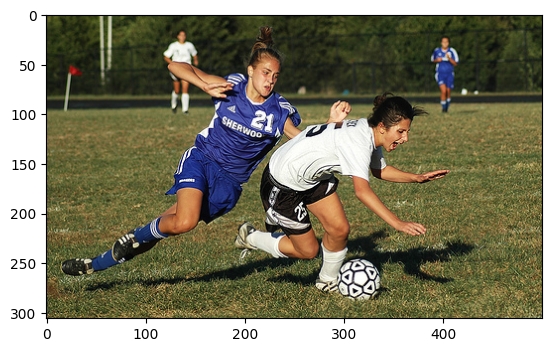

In [ ]:
# test method
generate_caption("47871819_db55ac4699.jpg")

# Testing

In [ ]:
random_image =  test_data[np.random.randint(0, len(test_data))]
test_image_path = os.path.join(os.getcwd(), "Images", random_image+".jpg")

image = load_img(test_image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = model.predict(image, verbose=0)

test_pred = greedy_search(model, feature, tokenizer, max_length)
image_plt = Image.open(test_img_path)

print(test_pred)
plt.imshow(image_plt)

ValueError: in user code:

    File "c:\Users\bhava\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\bhava\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\bhava\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\bhava\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\bhava\anaconda3\envs\tf2.4\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\bhava\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 224, 224, 3) dtype=float32>]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9bfae13a-423f-4a7e-bec2-36fb61b35837' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>